# Superposition

Last access (y.m.d): 19.08.30  
Last update (y.m.d): 19.08.30  

In this notebook, I'll look at truly testing the superposition aspect of the newer V1 experiments. In particular, for a given stimulus with dispersion > 1 (i.e. not just a single grating), the components of that stimulus will have been presented in isolation. This allows us to test $R_{1+2+..}$ against $R_1 + R_2 + ...$, where $_i$ are different stimulus components.

### Table of contents

- Example cell or experiment
   - suppression index (all conditions)  
   - sf tuning predictions   
   - rvc predictions  
- All V1 data   


In [2]:
import os
import numpy as np
import matplotlib
# matplotlib.use('TkAgg') # to avoid GUI/cluster issues...
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pltSave
import matplotlib.animation as anim
import matplotlib.cm as cm
import seaborn as sns
import itertools
import helper_fcns as hf
import autoreload
import scipy.optimize as opt
from scipy.stats.mstats import gmean as geomean

import sys # so that we can import model_responses (in different folder)
import model_responses

import warnings
warnings.filterwarnings('once');

%matplotlib inline

plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

basePath = os.getcwd() + '/'

In [3]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 8; # this is in style sheet, just being explicit
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 5; # no minor ticks
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 0; # no minor ticks

rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2;
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 0

rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

## Example cell or experiment

This section of code is used to look at just one cell or one experiment (e.g. all of V1_orig).

In this section, I outline some of the key components of the analysis and make helpful visualizations.

### Suppression index

In [198]:
## edit
expDir   = 'V1/';
dataListNm = hf.get_datalist(expDir);
descrFits_f0 = 'descrFits_190503_sach_flex.npy';
rvcName = 'rvcFits_190828_f1'

# expDir   = 'altExp/';
# dataListNm = 'dataList.npy'
# descrFits_f0 = 'descrFits_190503_poiss_flex.npy';
# rvcName = None

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = hf.np_smart_load(dataPath + dataListNm);

In [199]:
savePlt=1;
save_locSuper = save_loc + 'superposition/'
if not os.path.exists(save_locSuper):
    os.makedirs(save_locSuper)

In [200]:
# pick one cell?
# cells = [1]; 

# or do all?
cells = np.arange(1, 1+len(dataList['unitName']))

In [201]:
zr_rm = lambda x: x[x>0];
zr_rm_pair = lambda x, z: [x[np.logical_and(x>0, z>0)], z[np.logical_and(x>0, z>0)]];
# zr_rm_pair = lambda x, z: [x[np.logical_and(x>0, z>0)], z[np.logical_and(x>0, z>0)]] if np.logical_and(x!=[], z!=[])==True else [], [];

In [203]:
autoreload.reload(hf);

/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/.conda/envs/lcv-python/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


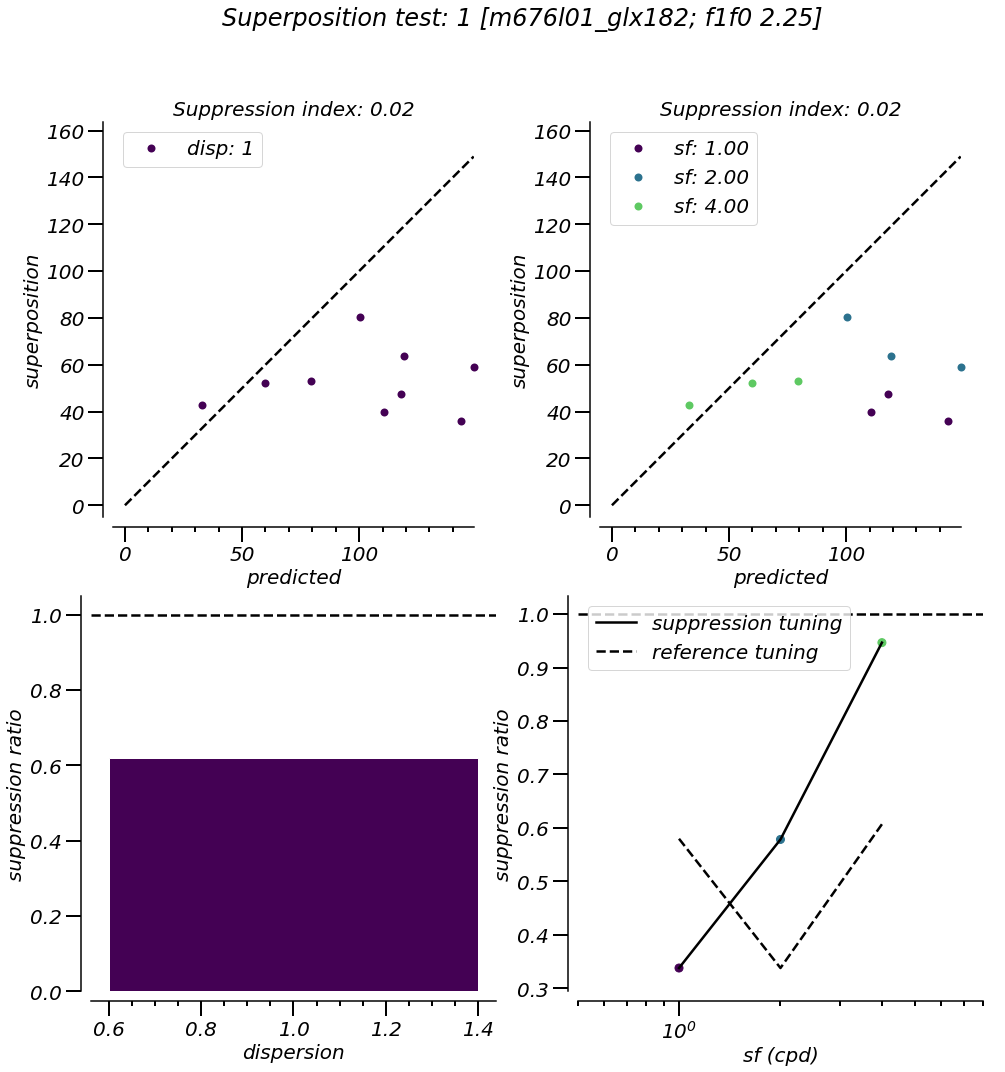

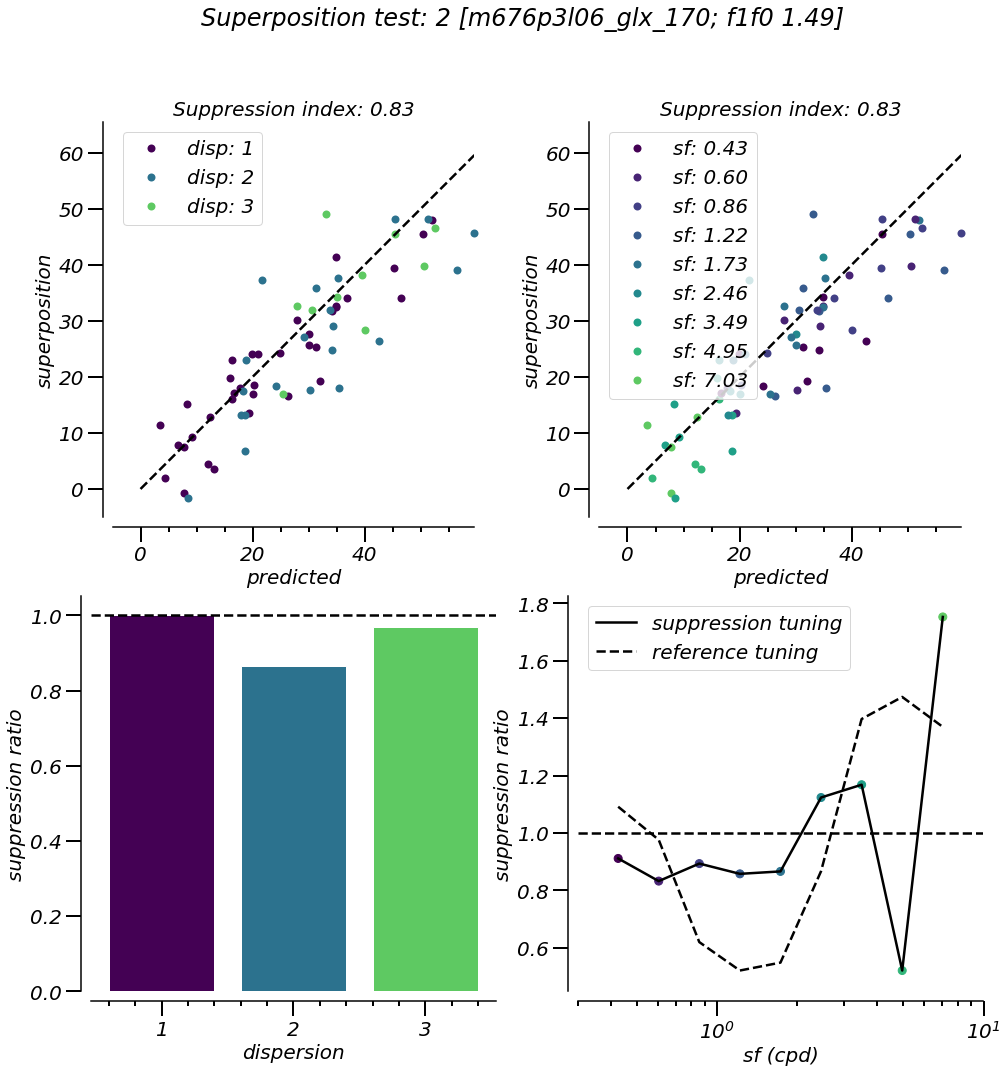

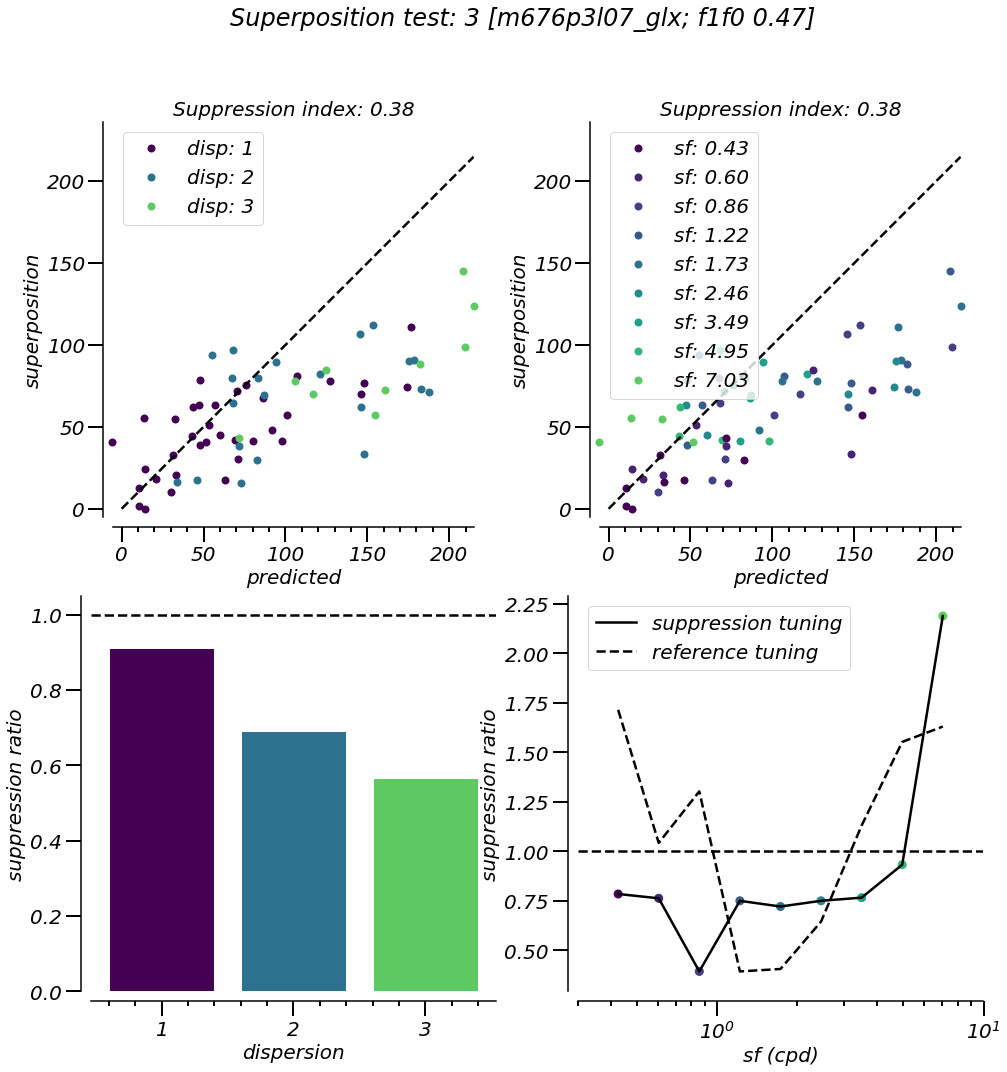

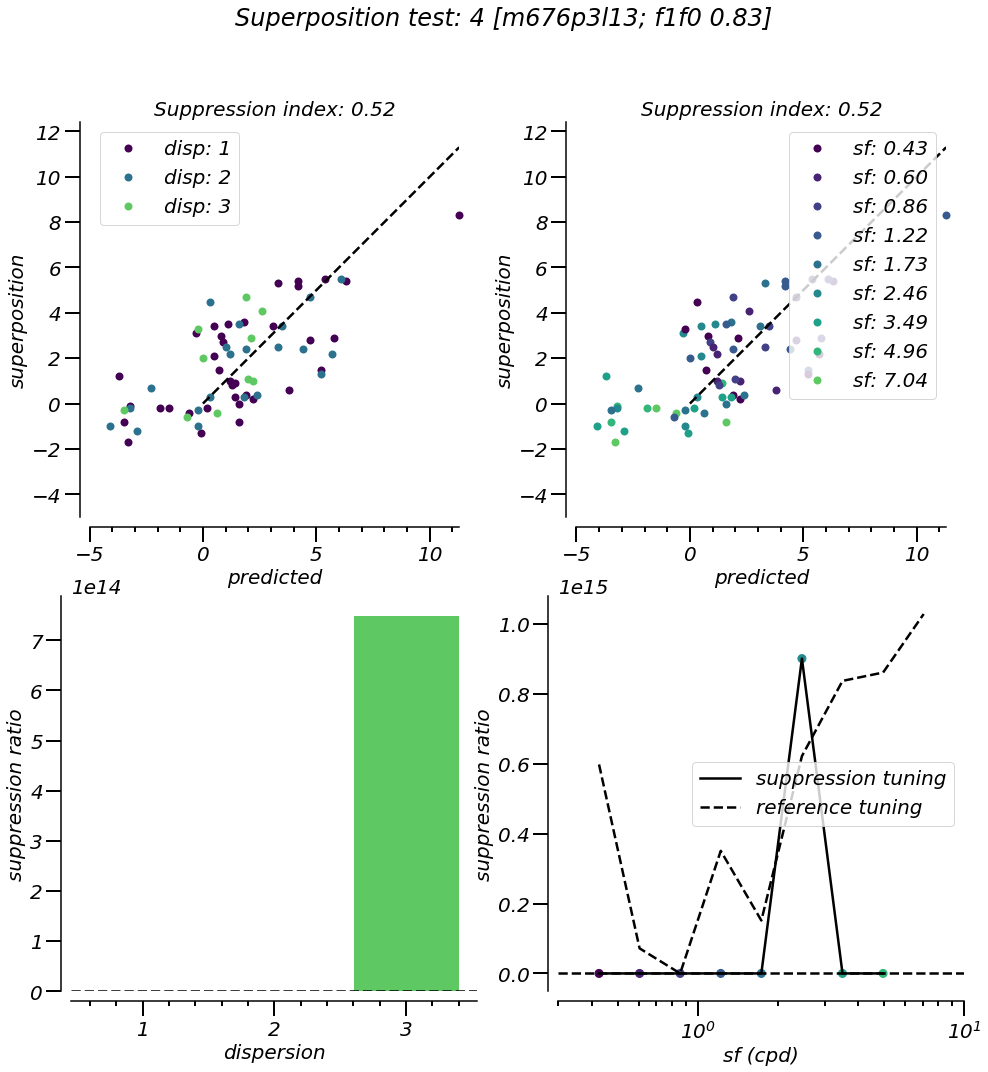

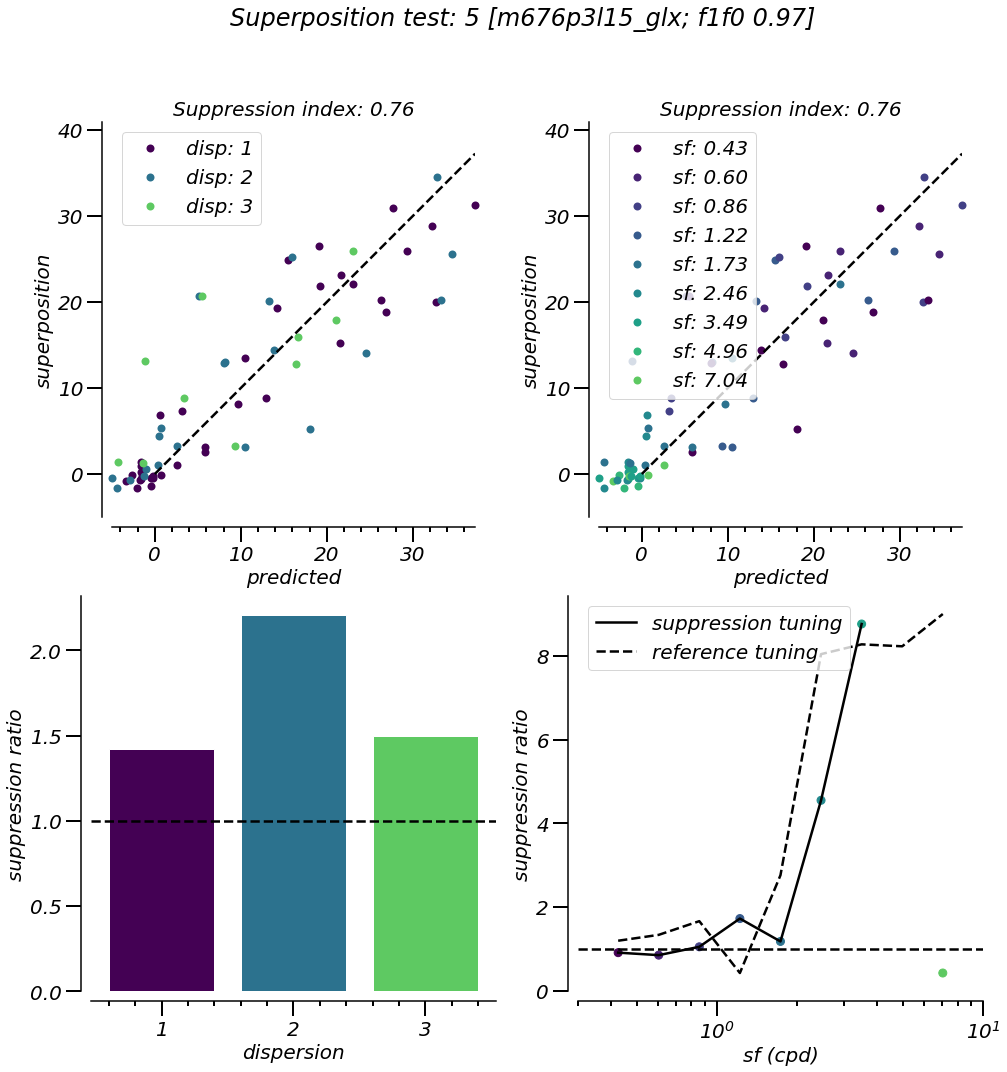

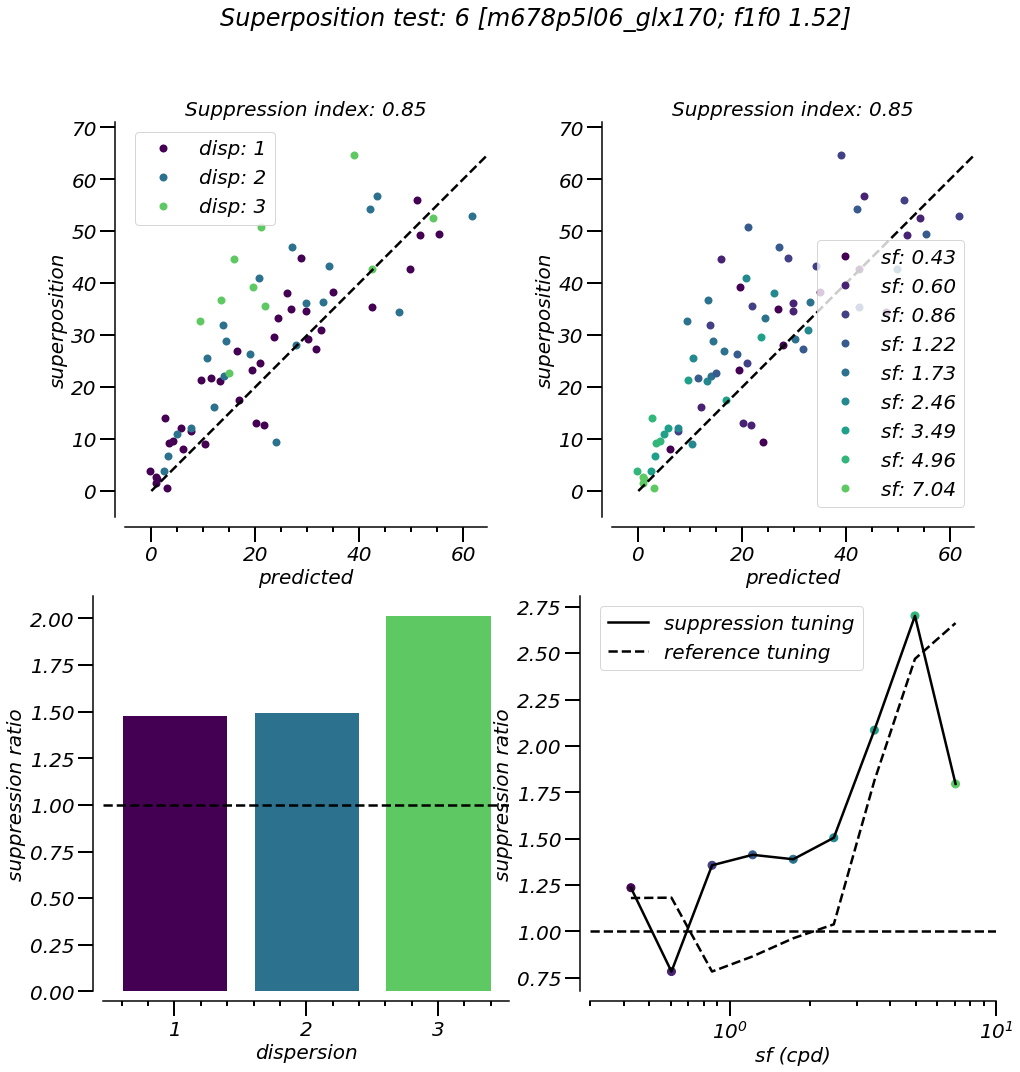

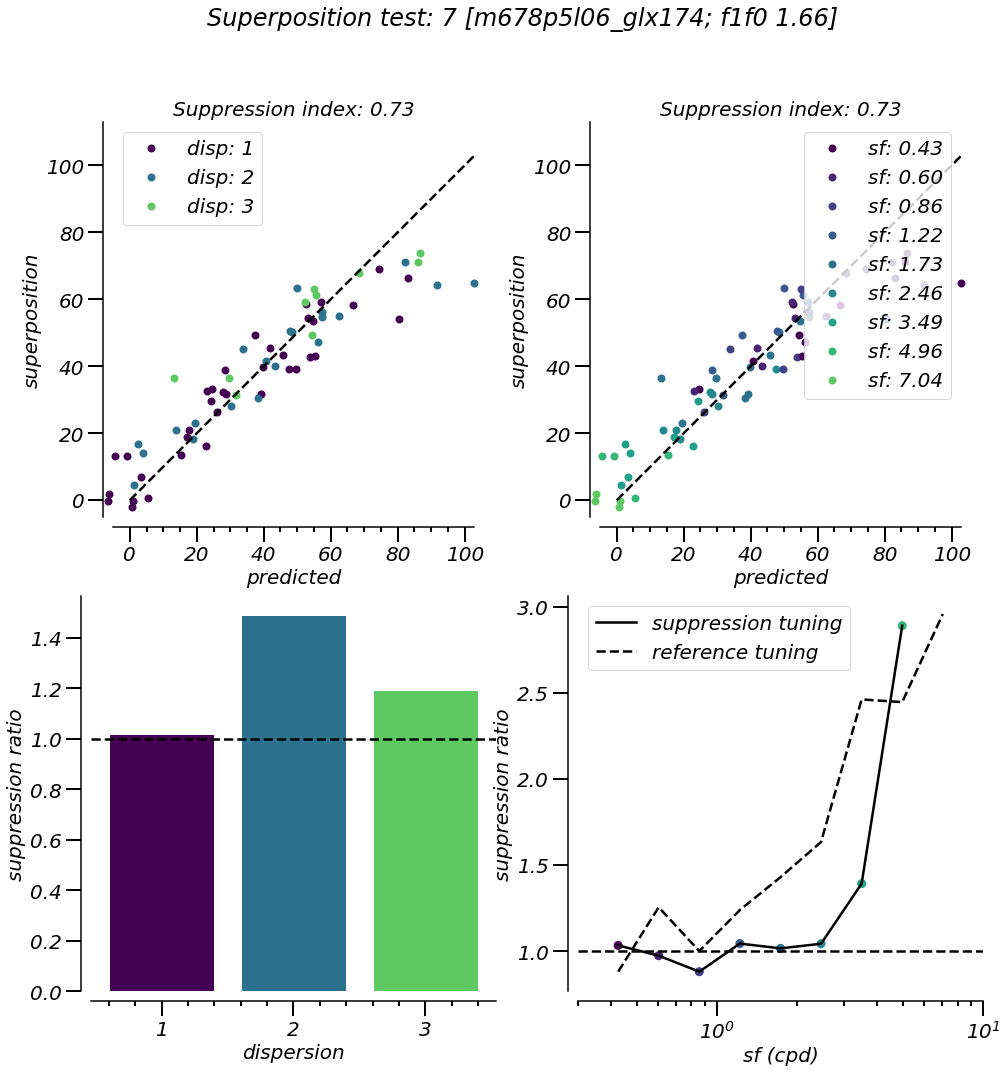

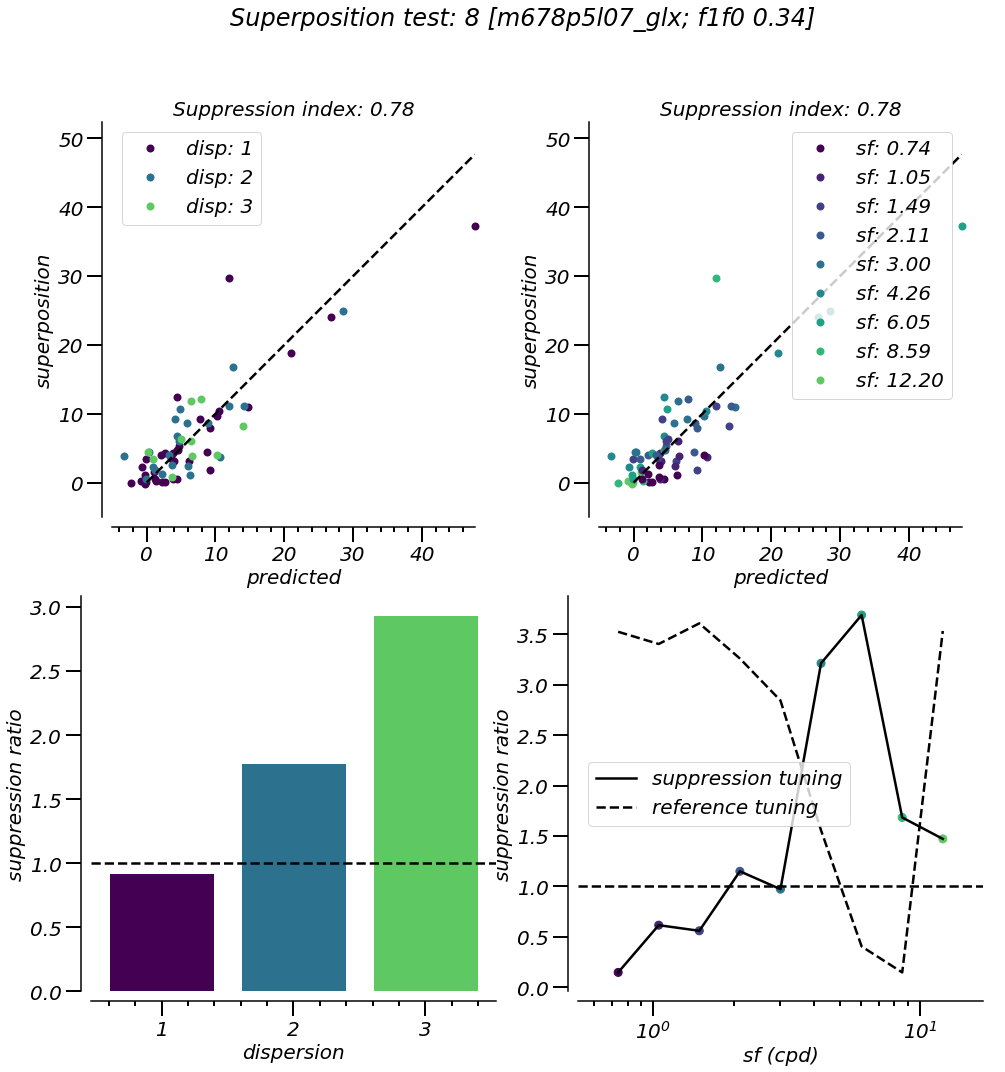

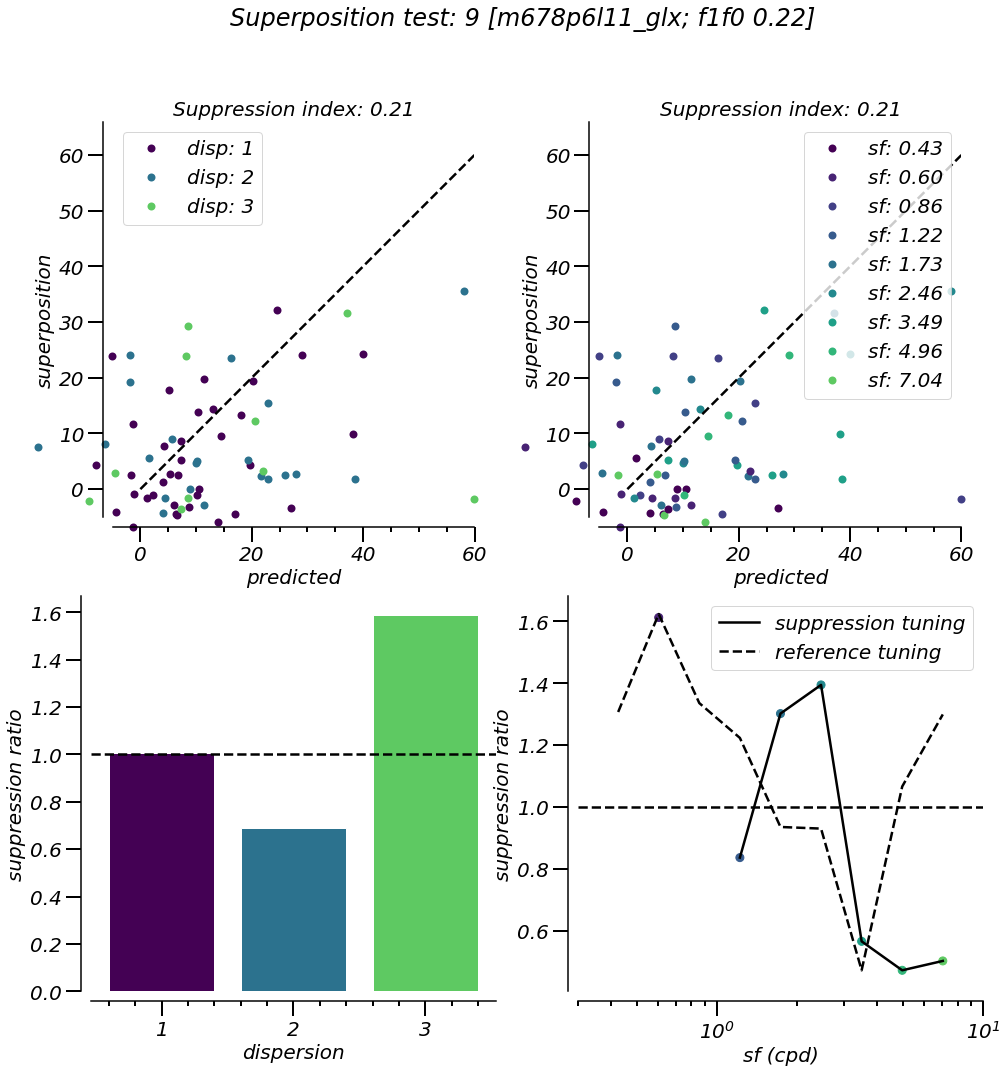

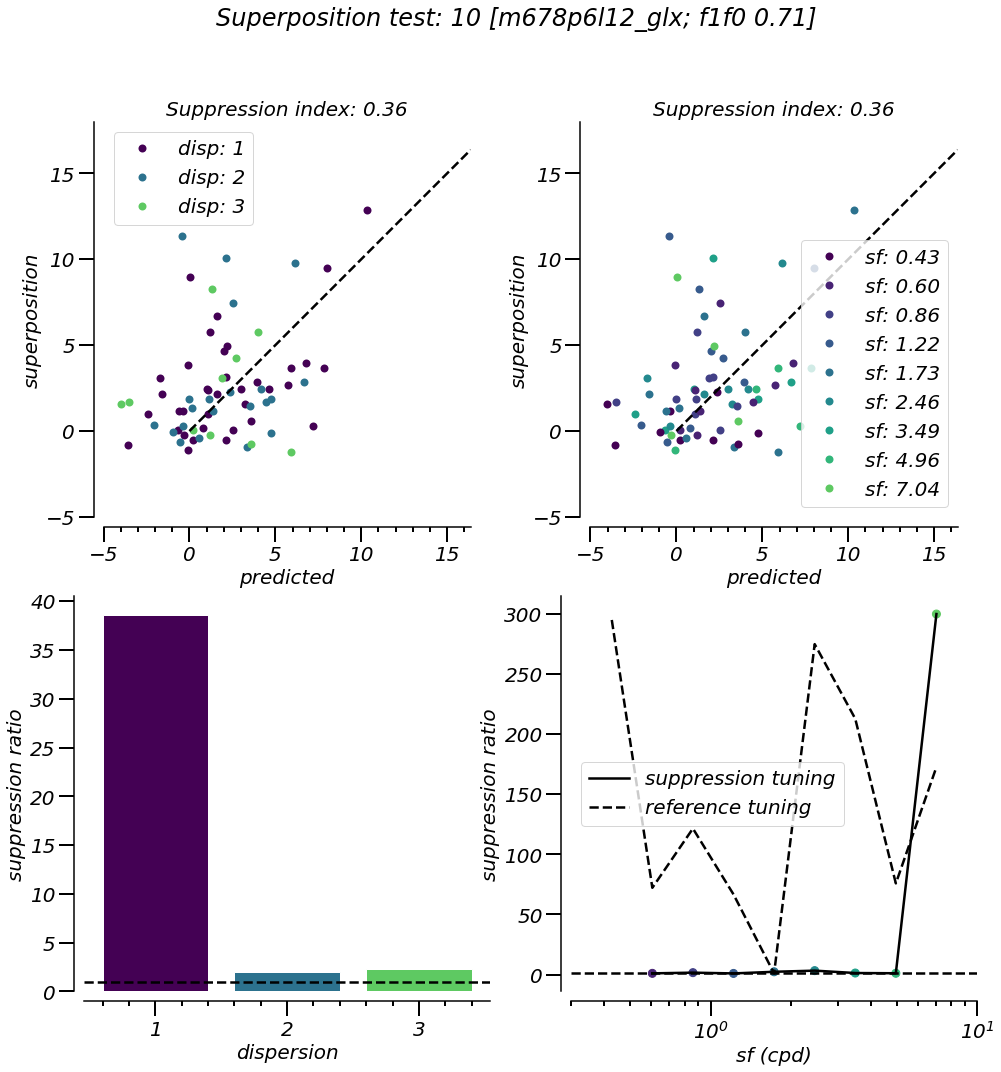

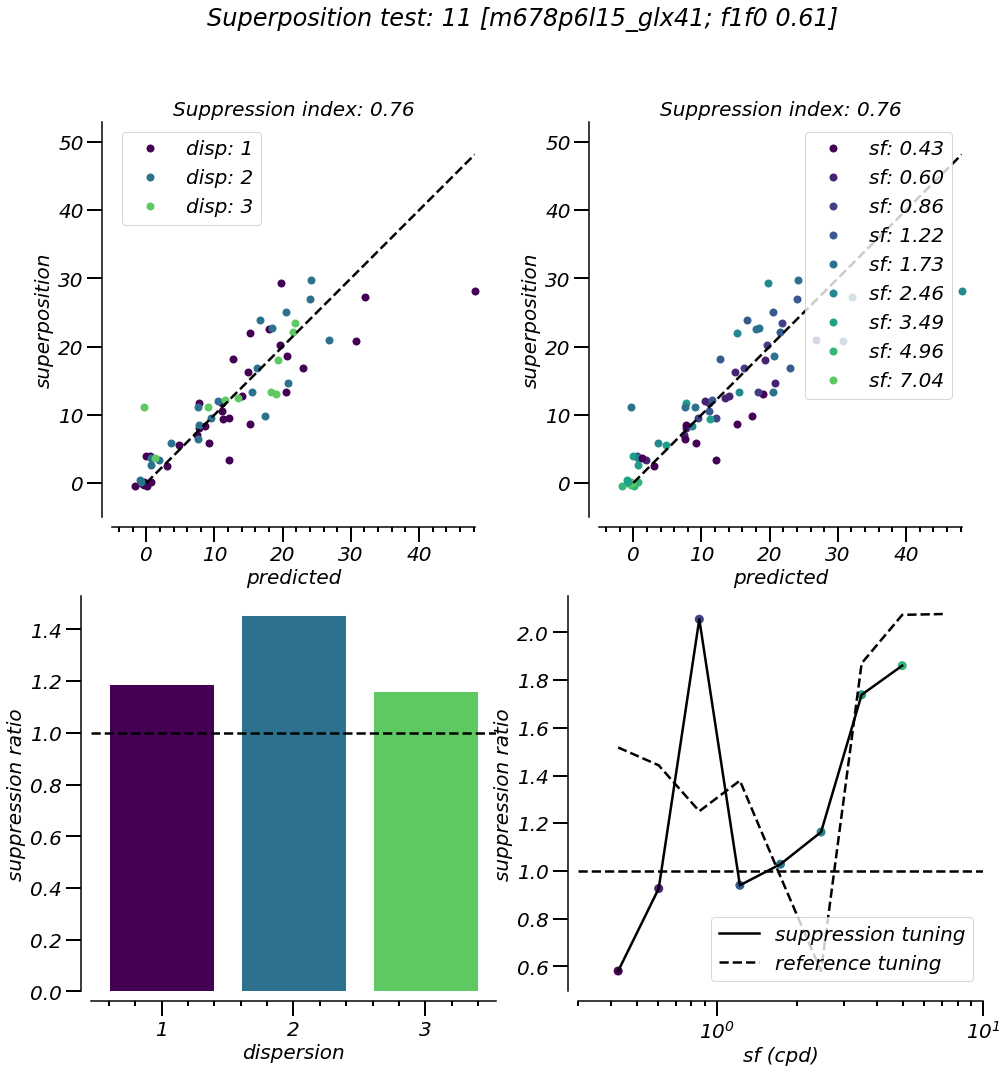

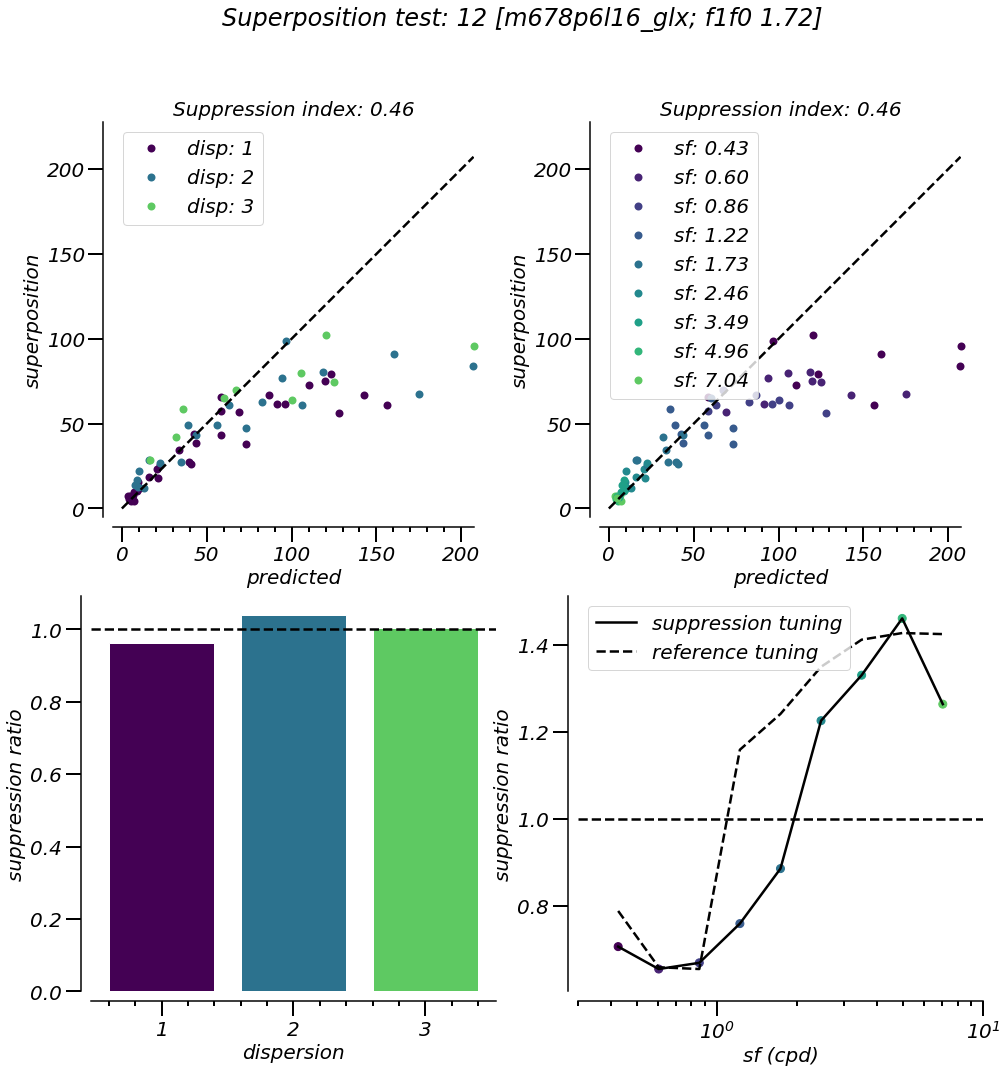

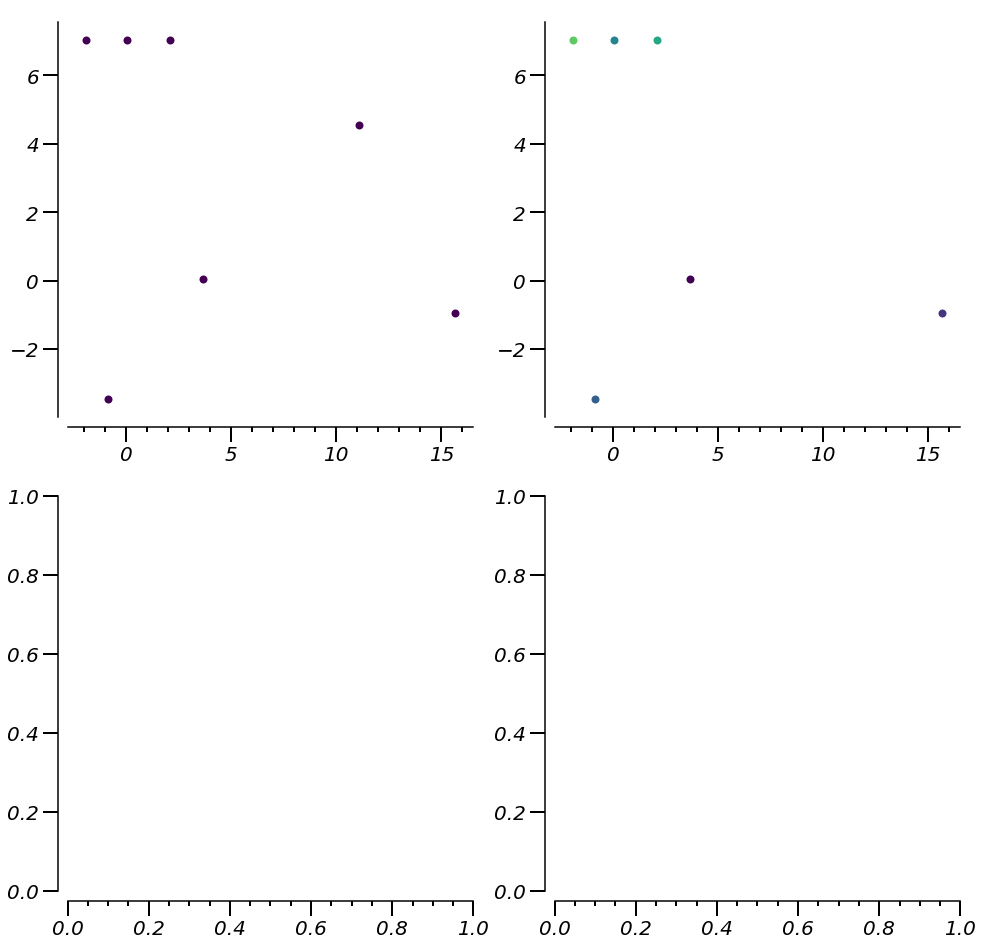

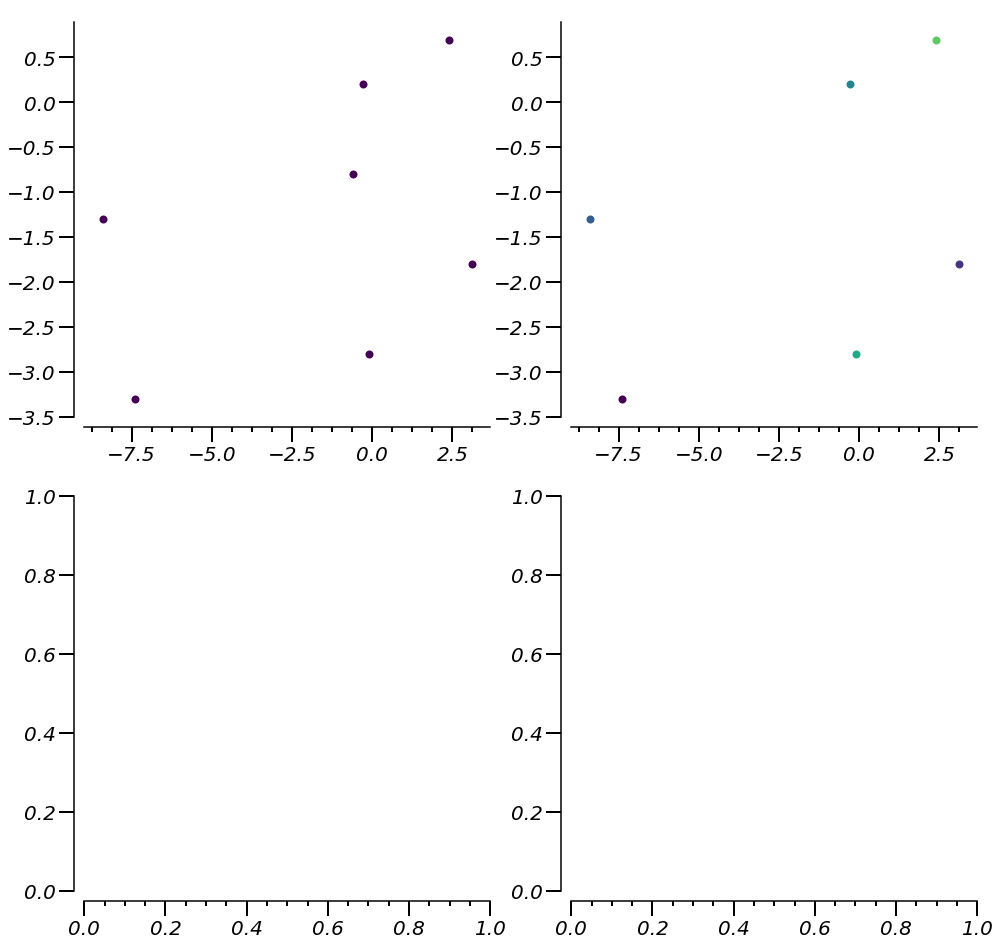

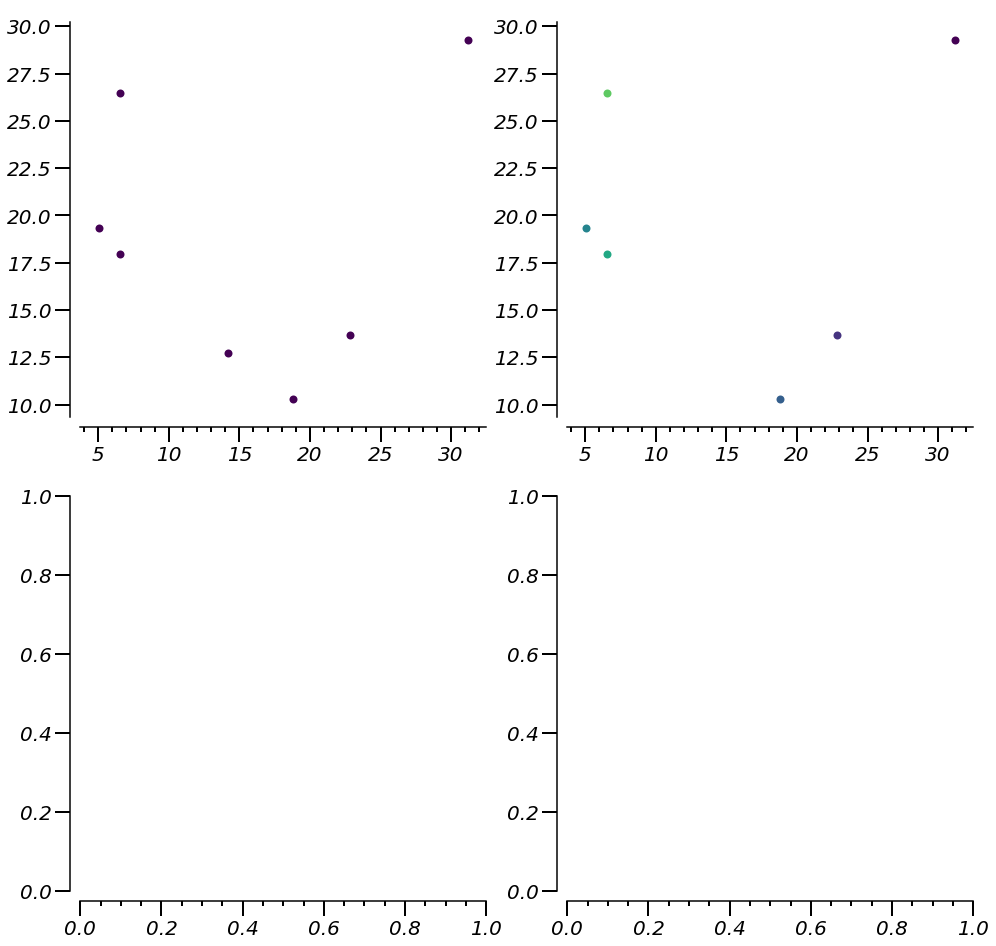

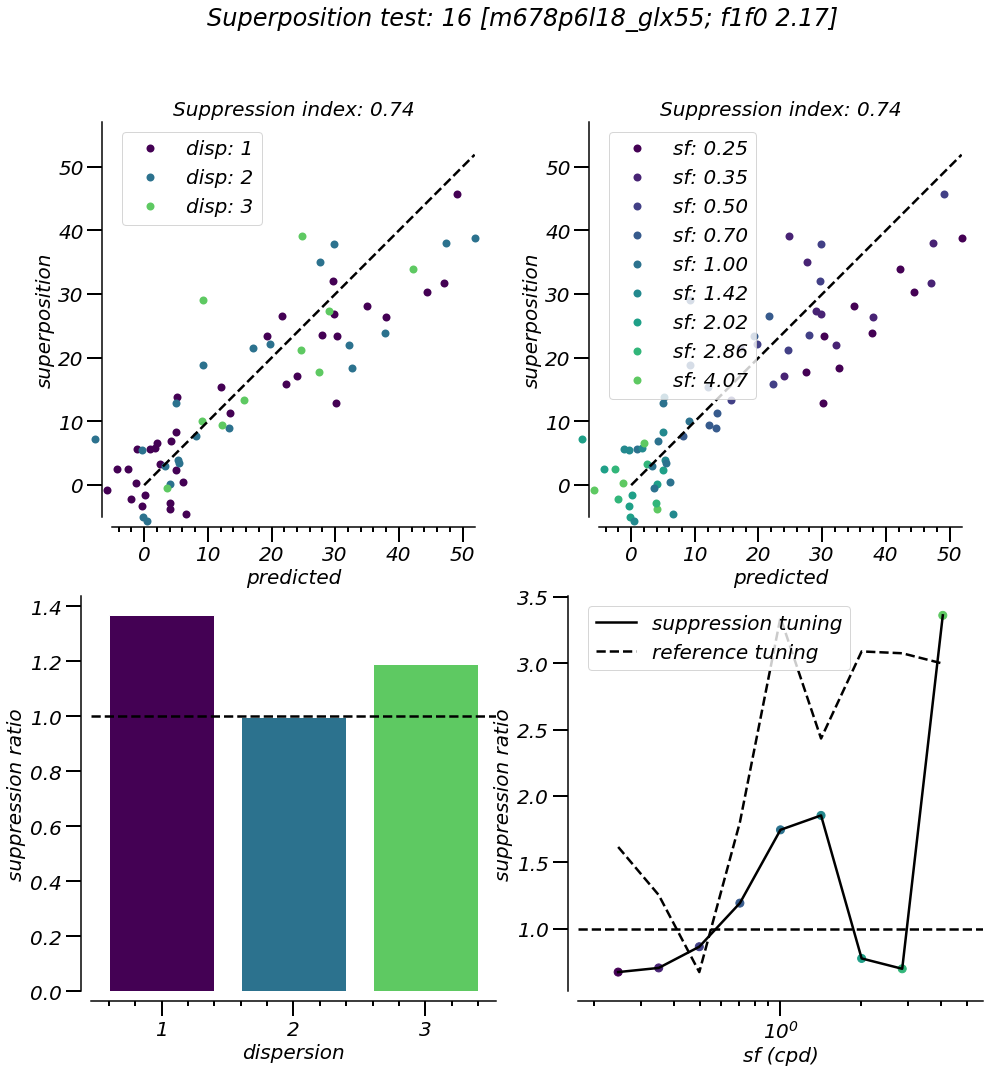

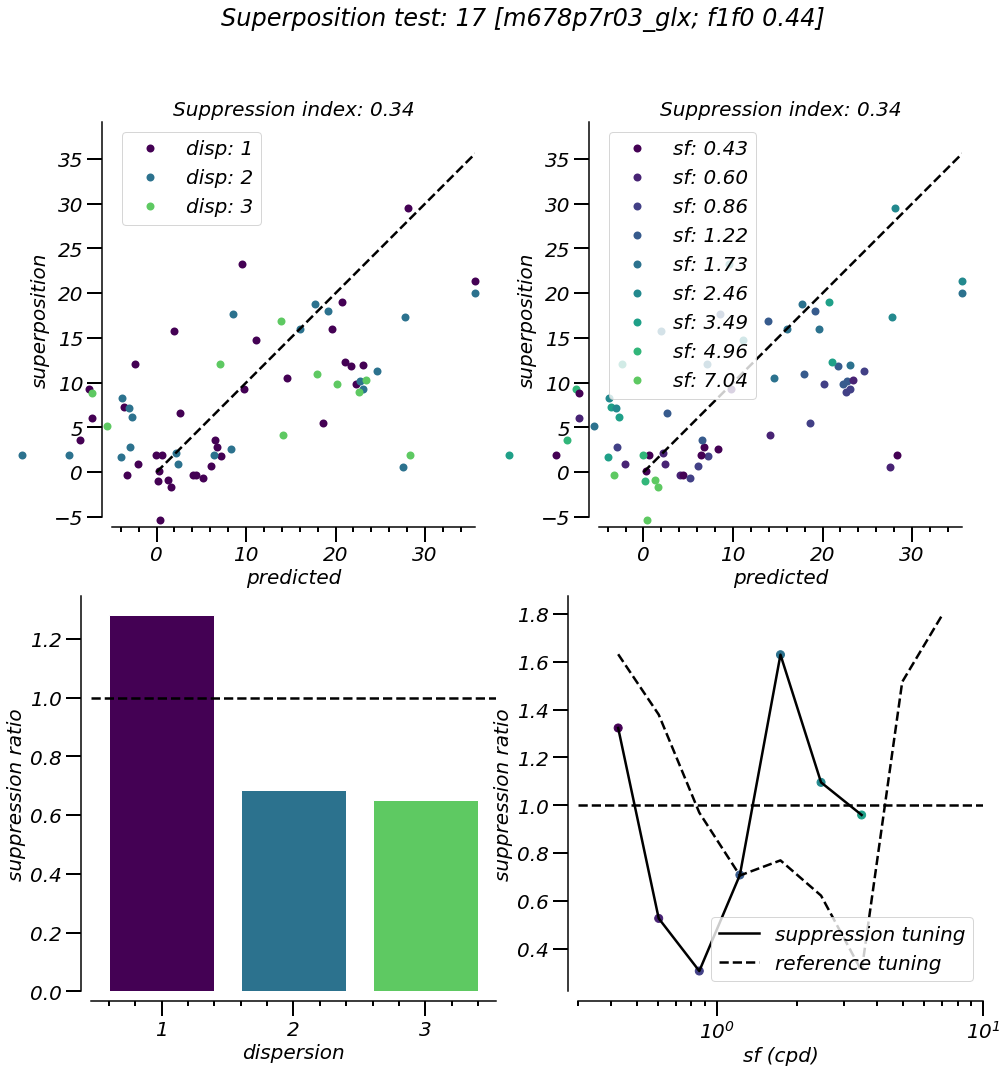

In [204]:
for i in cells:
    try:
        nRows, nCols = 2, 2;
        
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
        
        # first, compute f1f0 ratio to determine if we look at f0 or f1 response
        f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath, descrFitName_f0=descrFits_f0)[0];

        if f1f0_rat > 1: # i.e. if we're looking at a simple cell, then let's get F1
            if rvcName is not None:
                rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName);
            else:
                rvcFits = None
            spikes_byComp = hf.get_spikes(expData, get_f0=0, rvcFits=rvcFits, expInd=expInd);
            spikes = np.array([np.sum(x) for x in spikes_byComp]);
            rates = True; # when we get the spikes from rvcFits, they've already been converted into rates (in hf.get_all_fft)
            baseline = None; # f1 has no "DC", yadig?
        else: # otherwise, if it's complex, just get F0
            spikes = hf.get_spikes(expData, get_f0=1, rvcFits=None, expInd=expInd);
            rates = False; # get_spikes without rvcFits is directly from spikeCount, which is counts, not rates!
            baseline = hf.blankResp(expData, expInd)[0]; # we'll plot the spontaneous rate
            # why mult by stimDur? well, spikes are not rates but baseline is, so we convert baseline to count (i.e. not rate, too)
            spikes = spikes - baseline*hf.get_exp_params(expInd).stimDur; 
            
        _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
        resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=rates);
        predResps = resps[2];
    
        respMean = resps[0]; # equivalent to resps[0];
        respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition
        # compute SEM, too
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        maxResp = np.maximum(np.nanmax(respMean), np.nanmax(predResps));
        # by disp
        clrs_d = cm.viridis(np.linspace(0,0.75,nDisps-1));
        lbls_d = ['disp: %s' % str(x) for x in range(nDisps)];
        # by sf
        val_sfs = hf.get_valid_sfs(S, disp=1, con=val_con_by_disp[1][0], expInd=expInd) # pick 
        clrs_sf = cm.viridis(np.linspace(0,.75,len(val_sfs)));
        lbls_sf = ['sf: %.2f' % all_sfs[x] for x in val_sfs];
        # by con
        val_con = all_cons;
        clrs_con = cm.viridis(np.linspace(0,.75,len(val_con)));
        lbls_con = ['con: %.2f' % x for x in val_con];

        fSuper, ax = plt.subplots(nRows, nCols, figsize=(8*nCols, 8*nRows))
        sns.despine(fig=fSuper, offset=10)
        
        allMix = [];
        allSum = [];

        for d in range(nDisps):
            if d == 0: # we don't care about single gratings!
                continue; 
            v_cons = np.array(val_con_by_disp[d]);
            n_v_cons = len(v_cons);

            # plot split out by each contrast [0,1]
            for c in reversed(range(n_v_cons)):
                v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
                for s in v_sfs:
                    mixResp = respMean[d, s, v_cons[c]];
                    allMix.append(mixResp);
                    sumResp = predResps[d, s, v_cons[c]];
                    allSum.append(sumResp);
        #             print('condition: d(%d), c(%d), sf(%d):: pred(%.2f)|real(%.2f)' % (d, v_cons[c], s, sumResp, mixResp))
                    # PLOT in by-disp panel
                    if c == 0 and s == v_sfs[0]:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1], label=lbls_d[d], clip_on=False)
                    else:
                        ax[0, 0].plot(sumResp, mixResp, 'o', color=clrs_d[d-1], clip_on=False)
                    # PLOT in by-sf panel
                    sfInd = np.where(np.array(v_sfs) == s)[0][0]; # will only be one entry, so just "unpack"
                    if d == 1 and c == 0:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], label=lbls_sf[sfInd], clip_on=False);
                    else:
                        ax[0, 1].plot(sumResp, mixResp, 'o', color=clrs_sf[sfInd], clip_on=False);
                    # plot baseline, if f0...
#                     if baseline is not None:
#                         [ax[0, i].axhline(baseline, linestyle='--', color='k', label='spon. rate') for i in range(2)];

            # plot averaged across all cons/sfs (i.e. average for the whole dispersion) [1,0]
            mixDisp = respMean[d, :, :].flatten();
            sumDisp = predResps[d, :, :].flatten();
            mixDisp, sumDisp = zr_rm_pair(mixDisp, sumDisp);
            ax[1, 0].bar(d, np.mean(np.divide(mixDisp, sumDisp)), color=clrs_d[d-1]);
            if d == 1:
                ax[1, 0].set_xlabel('dispersion');
                ax[1, 0].set_ylabel('suppression ratio')
                ax[1, 0].axhline(1, ls='--', color='k')
            
        ### plot averaged across all cons/disps
        sfInds = []; sfRats = [];
        for s in range(len(val_sfs)):
            try: # not all sfs will have legitmate values;
                # only get mixtures (i.e. ignore single gratings)
                mixSf = respMean[1:, val_sfs[s], :].flatten();
                sumSf = predResps[1:, val_sfs[s], :].flatten();
                mixSf, sumSf = zr_rm_pair(mixSf, sumSf);
                sfInds.append(s); sfRats.append(np.mean(np.divide(mixSf, sumSf)))
            except:
                pass
        # get the offset/scale of the ratio so that we can plot a rescaled/flipped version of
        # the high con/single grat tuning for reference...does the suppression match the response?
        offset, scale = np.nanmax(sfRats), np.nanmax(sfRats) - np.nanmin(sfRats);
        sfRef = hf.nan_rm(respMean[0, val_sfs, -1]); # high contrast tuning
        sfRefShift = offset - scale * (sfRef/np.max(sfRef))
        ax[1,1].scatter(all_sfs[val_sfs][sfInds], sfRats, color=clrs_sf[sfInds], clip_on=False)
        ax[1,1].plot(all_sfs[val_sfs][sfInds], sfRats, 'k-', clip_on=False, label='suppression tuning')
        ax[1,1].plot(all_sfs[val_sfs], sfRefShift, 'k--', label='reference tuning', clip_on=False)
        ax[1,1].axhline(1, ls='--', color='k')
        ax[1,1].set_xlabel('sf (cpd)')
        ax[1,1].set_xscale('log')
        ax[1,1].set_xlim((np.min(all_sfs), np.max(all_sfs)));
        ax[1,1].set_ylabel('suppression ratio');
        ax[1,1].legend();
            
        # make a polynomial fit
        hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 

        for j in range(1):
            for jj in range(nCols):
                ax[j, jj].axis('square')
                ax[j, jj].set_xlabel('predicted');
                ax[j, jj].set_ylabel('superposition');
                ax[j, jj].plot([0, 1*maxResp], [0, 1*maxResp], 'k--')
                ax[j, jj].set_xlim((-5, maxResp));
                ax[j, jj].set_ylim((-5, 1.1*maxResp));
                ax[j, jj].set_title('Suppression index: %.2f' % hmm[0])
                ax[j, jj].legend();

        fSuper.suptitle('Superposition test: %d [%s; f1f0 %.2f]' % (which_cell, cellName, f1f0_rat))

        if savePlt:
            save_name = 'cell_%d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locSuper + save_name));
            pdfSv.savefig(fSuper)
            pdfSv.close();

    except: # i.e. ignore this cell - some cells have improper data/expo files
        pass;

### Predicted SF tuning

Now, let's get a sense for how the single gratings predict spatial frequency tuning to mixtures.

In [186]:
## edit
expDir   = 'V1/';
dataListNm = hf.get_datalist(expDir);
descrFits_f0 = 'descrFits_190503_sach_flex.npy';
rvcName = 'rvcFits_190828_f1'

# expDir   = 'altExp/';
# dataListNm = 'dataList.npy'
# descrFits_f0 = 'descrFits_190503_poiss_flex.npy';
# rvcName = None

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = hf.np_smart_load(dataPath + dataListNm);

In [187]:
savePlt=1;
save_locTune = save_loc + 'superposition/tuning_sf/'
if not os.path.exists(save_locTune):
    os.makedirs(save_locTune)

In [188]:
# pick one cell?
# cells = [3]; 

# or do all?
cells = np.arange(1, 1+len(dataList['unitName']))

In [189]:
# set up colors, labels                                                                                                                                                            
predClr = 'r';
predTxt = 'prediction';
dataClr = 'k';
dataTxt = 'data';
diffClr = 'b';
diffTxt = 'resp - pred';

In [190]:
for i in cells:

    try: # might have some bad cells, so we just continue/skip in that case
        ####
        ## gather information
        ####
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];

        # first, compute f1f0 ratio to determine if we look at f0 or f1 response
        f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath, descrFitName_f0=descrFits_f0)[0];

        if f1f0_rat > 1: # i.e. if we're looking at a simple cell, then let's get F1
            if rvcName is not None:
                rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName);
            else:
                rvcFits = None
            spikes_byComp = hf.get_spikes(expData, get_f0=0, rvcFits=rvcFits, expInd=expInd);
            spikes = np.array([np.sum(x) for x in spikes_byComp]);
            rates = True; # when we get the spikes from rvcFits, they've already been converted into rates (in hf.get_all_fft)
            baseline = None; # f1 has no "DC", yadig?
        else: # otherwise, if it's complex, just get F0 - and baseline subtract!
            spikes = hf.get_spikes(expData, get_f0=1, rvcFits=None, expInd=expInd);
            rates = False; # get_spikes without rvcFits is directly from spikeCount, which is counts, not rates!
            baseline = hf.blankResp(expData, expInd)[0]; # we'll plot the spontaneous rate
            spikes = spikes - baseline*hf.get_exp_params(expInd).stimDur; # why mult by stimDur? well, spikes are not rates but baseline is, so we convert baseline to count (i.e. not rate, too)
            
        _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
        resps, stimVals, val_con_by_disp, validByStimVal, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=rates);

        # get response mean/s.e.m.
        respMean = resps[0]; # could be resps[0], too...
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);
        # and prediction mean/
        predResps = resps[2];
        predStd   = resps[3];

        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        ####
        ## now we plot
        ####
        fDisp = []; dispAx = [];

        sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

        mixDisps = all_disps[all_disps>1]

        for d, d_val in enumerate(mixDisps):

            d_ind = d+1;
            v_cons = val_con_by_disp[d_ind];
            n_v_cons = len(v_cons);

            nPanels = 2;
            fCurr, dispCurr = plt.subplots(n_v_cons, nPanels, figsize=(nPanels*10, n_v_cons*6), sharey=False);
#             fCurr, dispCurr = plt.subplots(n_v_cons, nPanels, figsize=(nPanels*12, n_v_cons*8), sharey=False);
            fDisp.append(fCurr)
            dispAx.append(dispCurr);

            fCurr.suptitle('Superposition tuning: %d [%s; f1f0 %.2f]' % (which_cell, cellName, f1f0_rat))

            maxResp = np.max(np.max(respMean[d_ind, ~np.isnan(respMean[d_ind, :, :])]));
            maxPred = np.max(np.max(predResps[d_ind, ~np.isnan(predResps[d_ind, :, :])]));
            maxPlot = np.maximum(maxResp, maxPred);

            for c in reversed(range(n_v_cons)):
                c_plt_ind = len(v_cons) - c - 1;
                v_sfs = hf.get_valid_sfs(expData, d_ind, v_cons[c], expInd, stimVals, validByStimVal)

                curr_sfs  = all_sfs[v_sfs];
                curr_resp = respMean[d_ind, v_sfs, v_cons[c]]; # data response                                                                               
                curr_pred = predResps[d_ind, v_sfs, v_cons[c]]; # predicted response                                                                            

                ### LEFT SIDE: data versus prediction
                ## plot data                                                                                                                                                               
                dispAx[d][c_plt_ind, 0].errorbar(curr_sfs, curr_resp,
                                                 respSem[d_ind, v_sfs, v_cons[c]], color=dataClr, fmt='-o', clip_on=False, label=dataTxt);
        #         dispAx[d][c_plt_ind].axhline(blankMean, color=dataClr, linestyle='dashed', label='spon. rate');
                # and baseline if applicable
                if baseline is not None:
#                     dispAx[d][c_plt_ind, 0].axhline(baseline, linestyle='--', color='k', label='spon. rate')
                    dispAx[d][c_plt_ind, 0].set_ylabel('resp abv baseline (spikes/s)', fontsize='x-small');
                else:
                    dispAx[d][c_plt_ind, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');

                ## plot prediction
                dispAx[d][c_plt_ind, 0].plot(curr_sfs, curr_pred, linestyle='-', marker='o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][c_plt_ind, 0].errorbar(curr_sfs, curr_pred, predStd[d_ind, v_sfs, v_cons[c]], fmt='-o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][c_plt_ind].axhline(modSponRate, color=modClr, linestyle='dashed')

                ## labels
                dispAx[d][c_plt_ind, 0].set_ylim((0, 1.1*maxPlot));
                dispAx[d][c_plt_ind, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');

                ### RIGHT SIDE: difference plot
                ## plot difference
                curr_diff = curr_resp - curr_pred;
                dispAx[d][c_plt_ind, 1].plot(curr_sfs, curr_diff, ls='-', marker='o', color=diffClr, label=diffTxt)
                # and "no effect" line
                dispAx[d][c_plt_ind, 1].axhline(0, linestyle='--', color='k', label='pred. match')

                ## and then a rescaled version of the tuning curve for single gratings at high contrast
                # get the offset/scale of the ratio so that we can plot a rescaled of
                # the single grat tuning for reference...does the superposition failure match the response?
                # TODO: make reference curve not just high contrast?
                offset, scale = np.nanmin(curr_diff), np.nanmax(curr_diff) - np.nanmin(curr_diff);
                sfRef = hf.nan_rm(respMean[0, :, -1]); # high contrast tuning
                sfRefShift = offset + scale * (sfRef/np.max(sfRef))
                dispAx[d][c_plt_ind, 1].plot(all_sfs, sfRefShift, 'k-', label='reference tuning (d0, high con)', clip_on=False)

                ## labels
                dispAx[d][c_plt_ind, 1].set_ylabel('resp difference (spikes/)', fontsize='x-small');

                # Set ticks out, remove top/right axis, put ticks only on bottom/left
                for i in range(nPanels):
                    dispAx[d][c_plt_ind, i].legend(fontsize='xx-small'); # set up legend

                    dispAx[d][c_plt_ind, i].set_xlim((min(all_sfs), max(all_sfs)));
                    dispAx[d][c_plt_ind, i].set_xscale('log');
                    if c == 0: # i.e. only the last c_plt_ind
                        dispAx[d][c_plt_ind, i].set_xlabel('sf (c/deg)', fontsize='x-small');

                    dispAx[d][c_plt_ind, i].set_title('D%02d: contrast: %.3f' % (d_ind, all_cons[v_cons[c]]), fontsize='small');

                    dispAx[d][c_plt_ind, i].tick_params(labelsize=15, width=1, length=8, direction='out');
                    dispAx[d][c_plt_ind, i].tick_params(width=1, length=4, which='minor', direction='out'); # minor ticks, too...                                                            
                    sns.despine(ax=dispAx[d][c_plt_ind, i], offset=10, trim=False);
    
        if savePlt:
            save_name = 'cell_%d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locTune + save_name));
            for f in fDisp:
                pdfSv.savefig(f)
                plt.close(f)
            pdfSv.close();

    except: # i.e. ignore this cell - some cells have improper data/expo files
        pass;

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/LGN/helper_fcns.py:950: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  adjPred[d, sfInds[s], conInds[c]] = numpy.sum(x[0] for x in isolResp);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:2083: UserWarning: Tried to access f1 adjusted responses, defaulting to F1/F0 request
  warnings.warn('Tried to access f1 adjusted responses, defaulting to F1/F0 request');


### Predicted RVC

Now, let's get a sense for how the single gratings predict response versus contrast to mixture stimuli.

In [191]:
## edit
expDir   = 'V1/';
dataListNm = hf.get_datalist(expDir);
descrFits_f0 = 'descrFits_190503_sach_flex.npy';
rvcName = 'rvcFits_190828_f1'

# expDir   = 'altExp/';
# dataListNm = 'dataList.npy'
# descrFits_f0 = 'descrFits_190503_poiss_flex.npy';
# rvcName = None

## now, let it run
dataPath = basePath + expDir + 'structures/'
save_loc = basePath + expDir + 'figures/'

dataList = hf.np_smart_load(dataPath + dataListNm);

In [192]:
savePlt=1;
save_locTune = save_loc + 'superposition/tuning_rvc/'
if not os.path.exists(save_locTune):
    os.makedirs(save_locTune)

In [193]:
# set up colors, labels                                                                                                                                                            
predClr = 'r';
predTxt = 'prediction';
dataClr = 'k';
dataTxt = 'data';
diffClr = 'b';
diffTxt = 'resp - pred';

In [194]:
# pick one cell?
# cells = [3]; 

# or do all?
cells = np.arange(1, 1+len(dataList['unitName']))

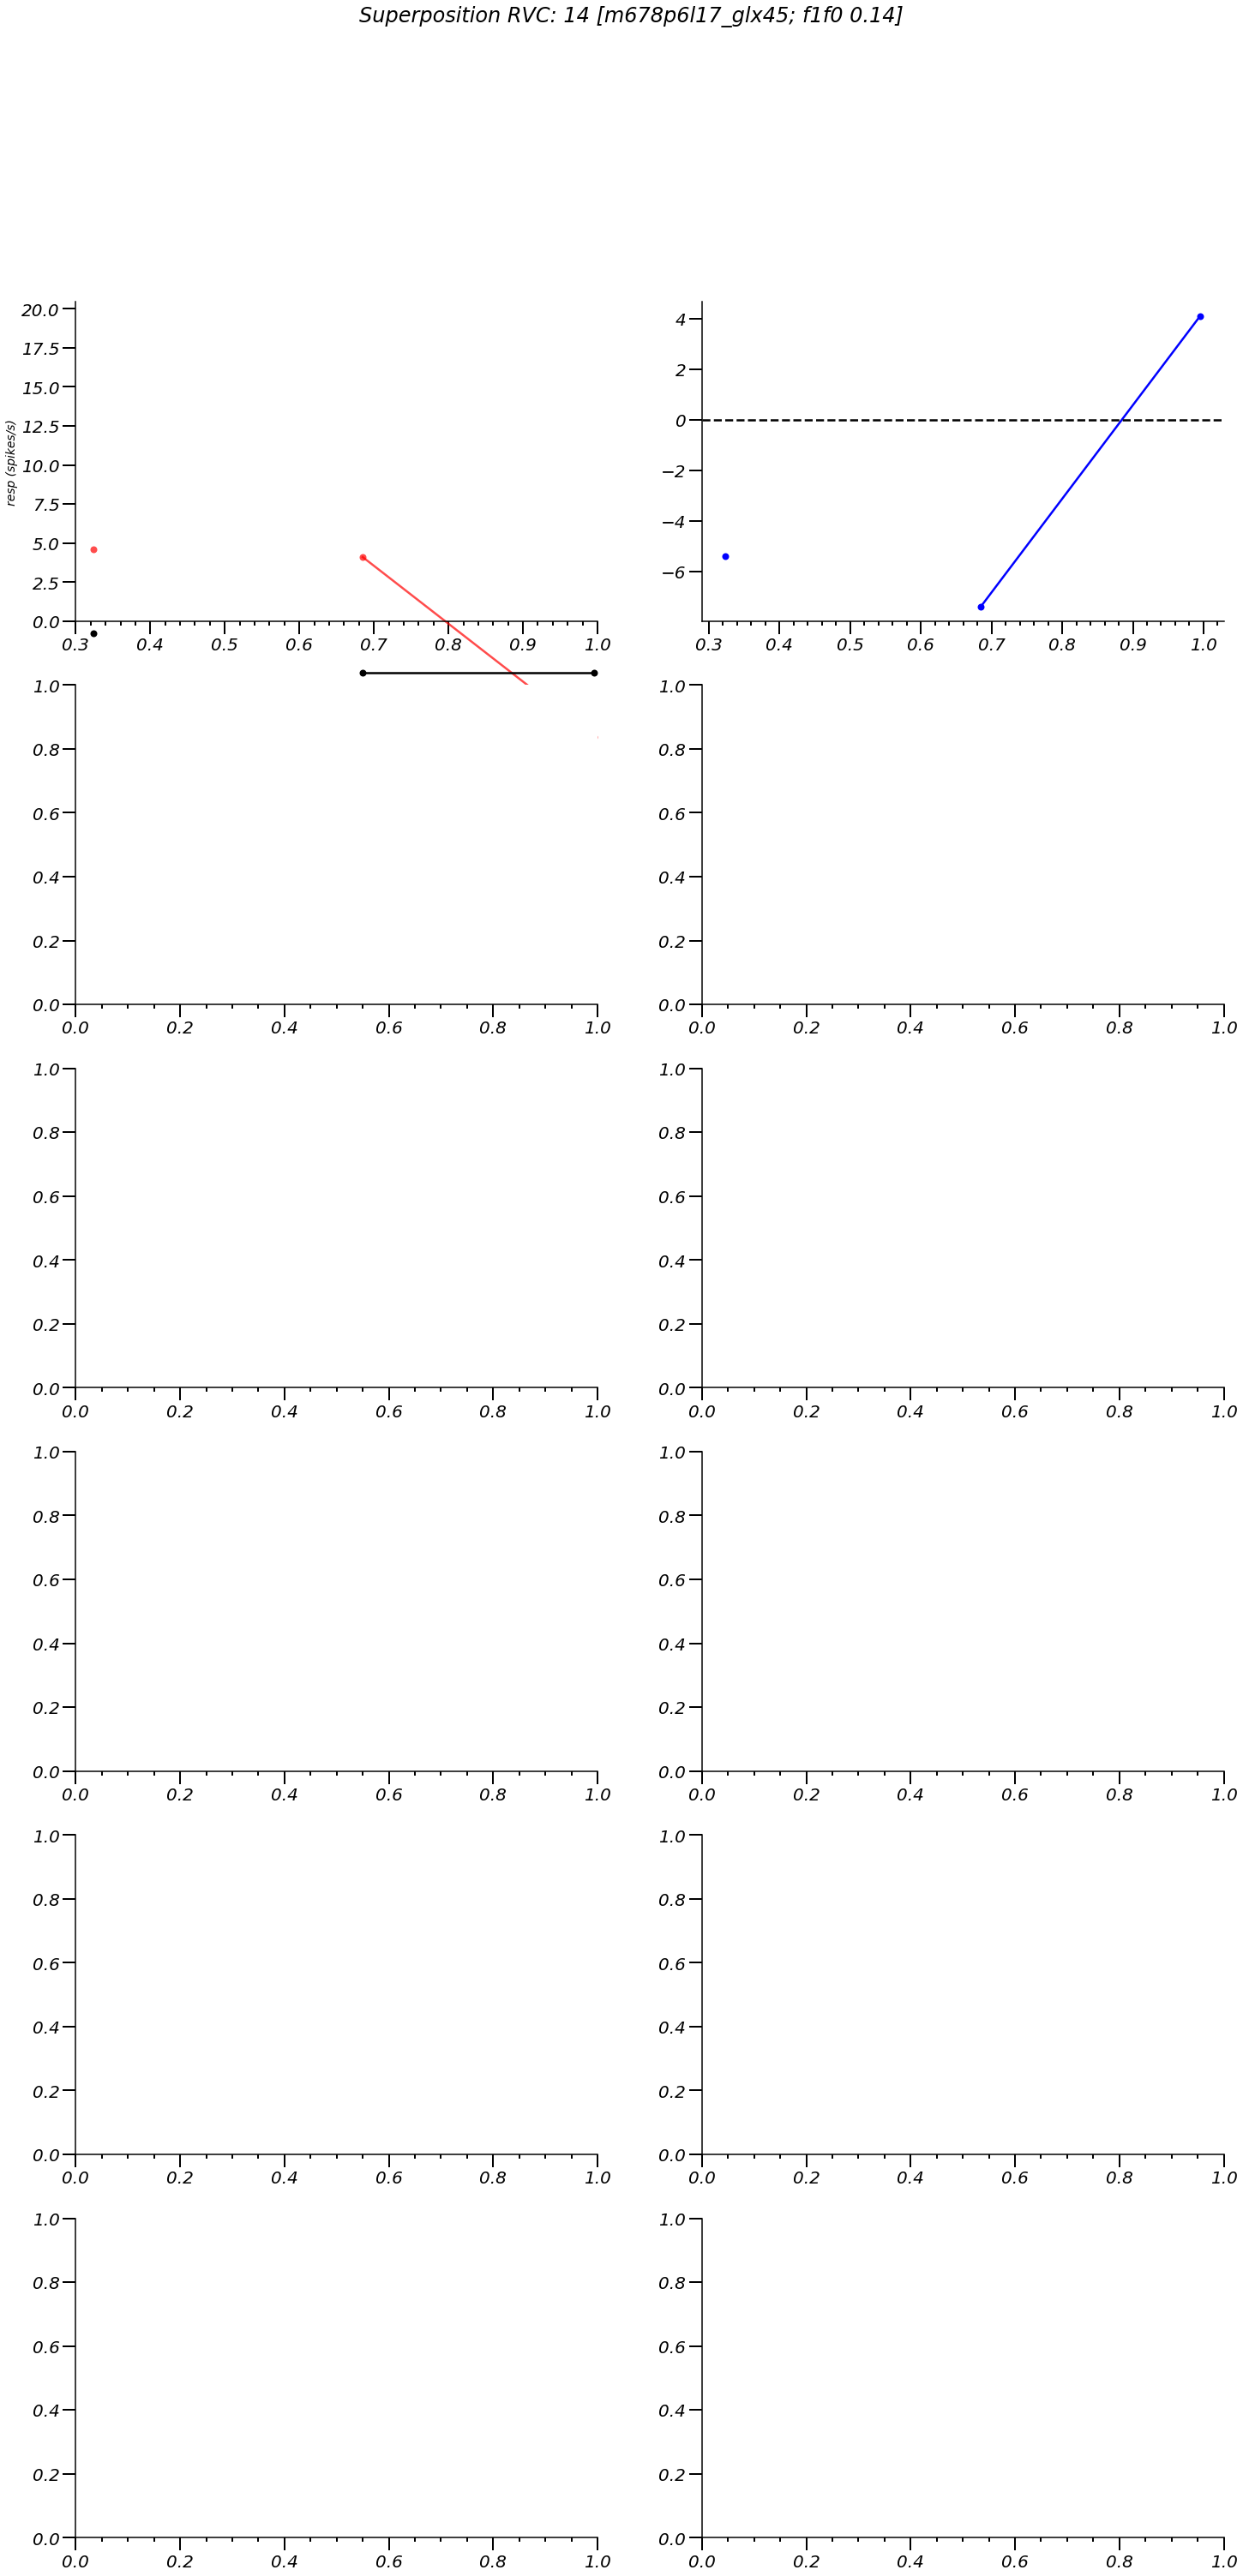

In [195]:
for i in cells:

    try: # might have some bad cells, so we just continue/skip in that case
        ####
        ## gather information
        ####
        which_cell = i; # which cell - index will be which_cell - 1
        cellName = dataList['unitName'][which_cell-1];
        expInd = hf.get_exp_ind(dataPath, cellName)[0]
        S = hf.np_smart_load(dataPath + cellName + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];

        # first, compute f1f0 ratio to determine if we look at f0 or f1 response
        f1f0_rat = hf.compute_f1f0(expData, which_cell, expInd, dataPath, descrFitName_f0=descrFits_f0)[0];

        if f1f0_rat > 1: # i.e. if we're looking at a simple cell, then let's get F1
            if rvcName is not None:
                rvcFits = hf.get_rvc_fits(dataPath, expInd, which_cell, rvcName=rvcName);
            else:
                rvcFits = None
            spikes_byComp = hf.get_spikes(expData, get_f0=0, rvcFits=rvcFits, expInd=expInd);
            spikes = np.array([np.sum(x) for x in spikes_byComp]);
            rates = True; # when we get the spikes from rvcFits, they've already been converted into rates (in hf.get_all_fft)
            baseline = None; # f1 has no "DC", yadig?
        else: # otherwise, if it's complex, just get F0
            spikes = hf.get_spikes(expData, get_f0=1, rvcFits=None, expInd=expInd);
            rates = False; # get_spikes without rvcFits is directly from spikeCount, which is counts, not rates!
            baseline = hf.blankResp(expData, expInd)[0]; # we'll plot the spontaneous rate
            # why mult by stimDur below? well, spikes are not rates but baseline is, so we convert baseline to count (i.e. not rate, too)
            spikes = spikes - baseline*hf.get_exp_params(expInd).stimDur;

            
        _, _, respOrg, respAll = hf.organize_resp(spikes, expData, expInd);
        resps, stimVals, val_con_by_disp, validByStimVal, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=spikes, respsAsRates=rates);

        # get response mean/s.e.m.
        respMean = resps[0]; # could be resps[0], too...
        findNaN = np.isnan(respAll);
        nonNaN  = np.sum(findNaN == False, axis=-1);
        respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);
        # and prediction mean/
        predResps = resps[2];
        predStd   = resps[3];

        ### organize stimulus information
        all_disps = stimVals[0];
        all_cons = stimVals[1];
        all_sfs = stimVals[2];

        nCons = len(all_cons);
        nSfs = len(all_sfs);
        nDisps = len(all_disps);

        ####
        ## now we plot
        ####
        fDisp = []; dispAx = [];

        sfs_plot = np.logspace(np.log10(all_sfs[0]), np.log10(all_sfs[-1]), 100);

        mixDisps = all_disps[all_disps>1]

        for d, d_val in enumerate(mixDisps):

            d_ind = d+1;

            v_sf_inds = hf.get_valid_sfs(expData, d_ind, val_con_by_disp[d_ind][0], expInd, stimVals, validByStimVal);
            n_v_sfs = len(v_sf_inds);

            nPanels = 2;
            fCurr, dispCurr = plt.subplots(n_v_sfs, nPanels, figsize=(nPanels*12, n_v_sfs*8), sharey=False);
            fDisp.append(fCurr)
            dispAx.append(dispCurr);

            fCurr.suptitle('Superposition RVC: %d [%s; f1f0 %.2f]' % (which_cell, cellName, f1f0_rat))

            maxResp = np.max(np.max(respMean[d_ind, ~np.isnan(respMean[d_ind, :, :])]));
            maxPred = np.max(np.max(predResps[d_ind, ~np.isnan(predResps[d_ind, :, :])]));
            maxPlot = np.maximum(maxResp, maxPred);

            for sf_ind_curr, sf_ind_total in enumerate(v_sf_inds):
                v_cons = val_con_by_disp[d_ind];
                curr_cons = all_cons[v_cons];

                curr_resp = respMean[d_ind, sf_ind_total, v_cons]; # data response                                                                               
                curr_pred = predResps[d_ind, sf_ind_total, v_cons]; # predicted response                                                                            

                ### LEFT SIDE: data versus prediction
                ## plot data                                                                                                                                                               
                dispAx[d][sf_ind_curr, 0].errorbar(curr_cons, curr_resp,
                                                 respSem[d_ind, sf_ind_total, v_cons], color=dataClr, fmt='-o', clip_on=False, label=dataTxt);
        #         dispAx[d][c_plt_ind].axhline(blankMean, color=dataClr, linestyle='dashed', label='spon. rate');
                # and baseline if applicable
                if baseline is not None:
#                     dispAx[d][c_plt_ind, 0].axhline(baseline, linestyle='--', color='k', label='spon. rate')
                    dispAx[d][sf_ind_curr, 0].set_ylabel('resp abv baseline (spikes/s)', fontsize='x-small');
                else:
                    dispAx[d][sf_ind_curr, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');

                ## plot prediction
                dispAx[d][sf_ind_curr, 0].plot(curr_cons, curr_pred, linestyle='-', marker='o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][sf_ind_curr, 0].errorbar(curr_sfs, curr_pred, predStd[d_ind, v_sfs, v_cons[c]], fmt='-o', alpha=0.7, color=predClr, clip_on=False, label=predTxt);
        #         dispAx[d][sf_ind_curr].axhline(modSponRate, color=modClr, linestyle='dashed')

                ## labels, lims
                dispAx[d][sf_ind_curr, 0].set_ylim((0, 1.1*maxPlot));
                dispAx[d][sf_ind_curr, 0].set_ylabel('resp (spikes/s)', fontsize='x-small');
                dispAx[d][sf_ind_curr, 0].set_xlim((0.3, np.max(all_cons)));

                ### RIGHT SIDE: difference plot
                ## plot difference
                curr_diff = curr_resp - curr_pred;
                dispAx[d][sf_ind_curr, 1].plot(curr_cons, curr_diff, ls='-', marker='o', color=diffClr, label=diffTxt)
                # and "no effect" line
                dispAx[d][sf_ind_curr, 1].axhline(0, linestyle='--', color='k', label='pred. match')

                ## and then a rescaled version of the tuning curve for single gratings at high contrast
                # get the offset/scale of the ratio so that we can plot a rescaled of
                # the single grat tuning for reference...does the superposition failure match the response?
                # TODO: make reference curve not just high contrast?
                offset, scale = np.nanmin(curr_diff), np.nanmax(curr_diff) - np.nanmin(curr_diff);
                v_cons_single = val_con_by_disp[0]
                sfRef = hf.nan_rm(respMean[0, :, -1]); # high contrast tuning
                sfPeak = np.argmax(sfRef); # stupid/simple, but just get the rvc for the max response
                rvcRef = hf.nan_rm(respMean[0, sfPeak, v_cons_single]);
                rvcRef_shift = offset + scale * (rvcRef/np.max(rvcRef))
                dispAx[d][sf_ind_curr, 1].plot(all_cons[v_cons_single], rvcRef_shift, 'k-', label='reference tuning (d0, peak SF)', clip_on=False)
                dispAx[d][sf_ind_curr, 1].set_xlim((np.min(all_cons), np.max(all_cons)));

                ## labels
                dispAx[d][sf_ind_curr, 1].set_ylabel('resp difference (spikes/)', fontsize='x-small');

                # Set ticks out, remove top/right axis, put ticks only on bottom/left
                for i in range(nPanels):
                    dispAx[d][sf_ind_curr, i].legend(fontsize='xx-small'); # set up legend

#                     dispAx[d][sf_ind_curr, i].set_xlim((min(curr_cons), max(curr_cons)));
                    dispAx[d][sf_ind_curr, i].set_xscale('log');
                    if c == 0: # i.e. only the last c_plt_ind
                        dispAx[d][sf_ind_curr, i].set_xlabel('contrast (%%)', fontsize='x-small');

                    dispAx[d][sf_ind_curr, i].set_title('D%02d: sf: %.2f' % (d_ind, all_sfs[sf_ind_total]), fontsize='small');

                    dispAx[d][sf_ind_curr, i].tick_params(labelsize=15, width=1, length=8, direction='out');
                    dispAx[d][sf_ind_curr, i].tick_params(width=1, length=4, which='minor', direction='out'); # minor ticks, too...                                                            
                    sns.despine(ax=dispAx[d][sf_ind_curr, i], offset=10, trim=False);
    
        if savePlt:
            save_name = 'cell_%d.pdf' % which_cell
            pdfSv = pltSave.PdfPages(str(save_locTune + save_name));
            for f in fDisp:
                pdfSv.savefig(f)
                plt.close(f)
            pdfSv.close();

    except: # i.e. ignore this cell - some cells have improper data/expo files
        pass;

## Full analysis

Here, we'll try to further develop superposition analysis for all possible cells. Importantly, we can only analyze altExp/ and V1/ experiments (i.e. not V1_orig/) due to the needed construction of the stimulus set. Recall that the superposition analysis seeks to predict the response to mixture stimuli from the responses to constituent gratings when presented alone.

Now, let's gather the same pred/mix responses for all cells

In [ ]:
suppInds = [];
for nm, ind in zip(dataList['unitName'], range(len(dataList['unitName']))):
    
    try:
        # load cell
        expInd = hf.get_exp_ind(dataPath, nm)[0]
        S = hf.np_smart_load(dataPath + nm + '_sfm.npy')
        expData = S['sfm']['exp']['trial'];
    except:
        continue;
    
    ### organize responses
    resps, stimVals, val_con_by_disp, _, _ = hf.tabulate_responses(expData, expInd);
    ### WARNING: WARNING: resps is WITHOUT any rvcAdjustment
    predResps = resps[2];
    rvcFits = hf.get_rvc_fits(dataPath, expInd, ind, rvcName='None');
    spikes  = hf.get_spikes(expData, rvcFits=rvcFits, expInd=expInd);
    _, _, respOrg, respAll    = hf.organize_resp(spikes, expData, expInd);

    respMean = respOrg;
    respStd = np.nanstd(respAll, -1); # take std of all responses for a given condition                                                                                                                         
    # compute SEM, too                                                                                                                                                                                          
    findNaN = np.isnan(respAll);
    nonNaN  = np.sum(findNaN == False, axis=-1);
    respSem = np.nanstd(respAll, -1) / np.sqrt(nonNaN);

    ### organize stimulus information
    all_disps, all_cons, all_sfs = stimVals[0:3];
    nCons, nSfs, nDisps = len(all_cons), len(all_sfs), len(all_disps);
    
    allMix = [];
    allSum = [];

    for d in range(nDisps):
        if d == 0: # we don't care about single gratings!
            continue; 
        v_cons = np.array(val_con_by_disp[d]);
        n_v_cons = len(v_cons);

        for c in reversed(range(n_v_cons)):
            v_sfs = hf.get_valid_sfs(S, d, v_cons[c], expInd)
            for s in v_sfs:
                mixResp = respMean[d, s, v_cons[c]];
                allMix.append(mixResp);
                sumResp = predResps[d, s, v_cons[c]];
                allSum.append(sumResp);
    
    hmm = np.polyfit(allSum, allMix, deg=1) # returns [a, b] in ax + b 
    suppInds.append(hmm[0])
    

## Extra/old

In [ ]:
################
## DO YOU WANT TO RUN THIS?
## DEBUGGING new changes in tabulate_responses --- works!
################
resps_GT, stimVals_GT, val_con_by_disp_GT, _, _ = hf.tabulate_responses(expData, expInd);
resps_F0, stimVals_F0, val_con_by_disp_F0, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=expData['spikeCount']);
f1_sum = np.array([np.sum(x)for x in expData['f1']]);
resps_F1, stimVals_F1, val_con_by_disp_F1, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=f1_sum);
f1_sum_adj = spikes
resps_F1_adj, stimVals_F1_adj, val_con_by_disp_F1_adj, _, _ = hf.tabulate_responses(expData, expInd, overwriteSpikes=f1_sum_adj);